# Analysis of MEV rewards in ETH2

This analysis is executed alongside the [post]() we've released on MEV in eth2. Thanks to Taarush Vemulapalli and Alejo Salles for their contributions, as well as Pintail for the original code this analysis is based on.

We re-use the code from [this article](https://pintail.xyz/posts/beacon-chain-validator-rewards/) by Pintail, adding additional considerations for MEV rewards using Flashbots data as a proxy for it. The Flashbots data we use has been collected by running an MEV-Geth node, querying the public [mev-blocks API](https://blocks.flashbots.net) and looking at data in the [public dashboard](https://dashboard.flashbots.net) of Flashbots activity.

In [43]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import numpy as np

EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952

# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(no_of_validators): # mean
    return SECONDS_PER_YEAR / (12 * no_of_validators) # 12 seconds = 1 slot

# Accounting for probability of producing a block
def unluckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.01],31556952/12,1/no_of_validators)

def luckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.99],31556952/12,1/no_of_validators)

avg_mev_reward_per_block = 0.297 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = 10e6 # 10M
validators_on_the_network_today = 160000 # may 27
block_selection_frequency_flashbots = 58 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles

### Ideal case on infinite timescale
Let's consider first the case where:
* all validators participate perfectly and get the maximum reward they can get (i.e. $4*\text{base reward}$ - there is no slashing)
* all rewards are distributed evenly since every validator has an equal chance of being selected to produce a block, so on an infinite timescale rewards should even out.

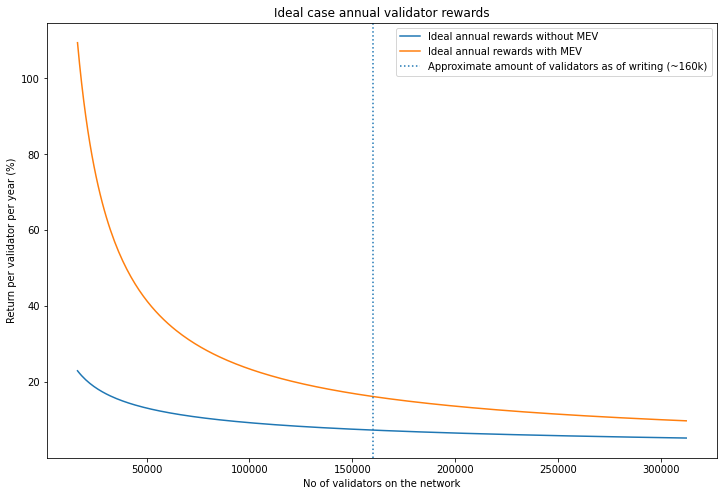

In [44]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) ) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Ideal case annual validator rewards')
leg = ax.legend()

Below is a table showing the values in the graph above at different number of validators:


In [45]:
# tabulate returns for various amounts of validators with and without MEV
# setup an array of various # of possible active validators
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 160000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)  * (block_selection_frequency_flashbots/100))) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]
percentage_increase = []
for i in range(len(annual_yield)):
    percentage_increase.append((annual_yield_with_mev[i]/annual_yield[i]-1)*100)
data = {
    '# of validators': n_validators,
    'annual reward (ETH)': ideal_reward,
    'annual reward with mev (ETH)':ideal_reward_with_mev,
    'annual validator yield (%)': annual_yield,
    'annual validator yield with mev (%)': annual_yield_with_mev,
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('# of validators')

,annual reward (ETH),annual reward with mev (ETH),annual validator yield (%),annual validator yield with mev (%)
# of validators,,,,
16384,7.35,35.00,22.97,109.37
50000,4.21,13.27,13.15,41.46
100000,2.98,7.51,9.30,23.45
120000,2.72,6.49,8.49,20.28
150000,2.43,5.45,7.59,17.03
160000,2.35,5.18,7.35,16.20
200000,2.10,4.37,6.57,13.65
250000,1.88,3.69,5.88,11.54
300000,1.72,3.23,5.37,10.09


At the current level of validators (~160k), we find that MEV can increase validator rewards by 120%, or give an implied yield of 16.2% rather than non-MEV yield of 7.35%. 

### ideal case on 1y timescale
Over any finite timescale, there will be variability in rewards, since some validators will be lucky and be given the opportunity to propose a greater than average number of blocks, and some unlucky, proposing fewer. We can find the distribution of luck for block proposal frequency in a year using the binomial distribution formula:
- every validator has an equal chance of being selected to propose each slot
    - if there are 100,000 validators then the chance of being selected to propose a slot is $10^{-5}$
- there are $\ 31556952 / 12 = 2629746$ slots per year. 

For 100,000 validators, this give us $$P(X) = {{2629746}\choose{k}} \cdot (10^{-5})^k{(1-10^{-5})}^{2629746-k}$$

With 100,000 validators, the mean number of blocks proposed per validator per year is 26.30

The unluckiest 1% of validators will have the opportunity to produce at most 15 blocks in a year
The median (average) validator will have the opportunity to produce 26 blocks in a year
The luckiest 1% of validators will have the opportunity to produce at least 39 blocks in a year


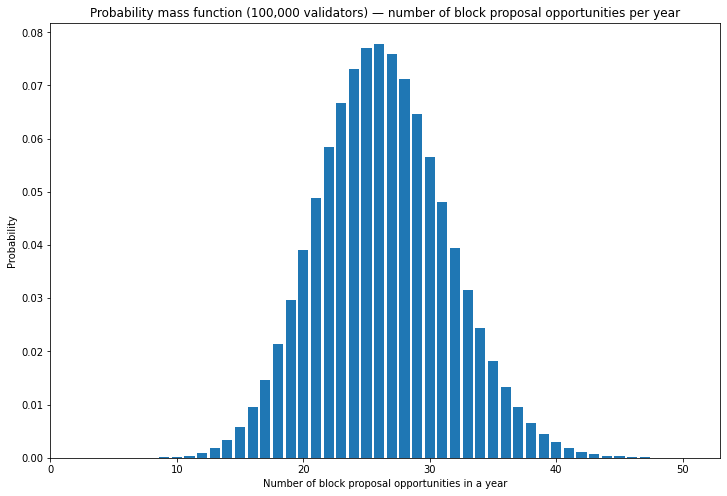

In [46]:
from scipy.stats import binom

x = [el for el in range(51)]
y = binom.pmf(x, 31556952/12, 1e-5)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x, y)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_title('Probability mass function (100,000 validators) — number of block proposal opportunities per year')
ax.set_xlabel('Number of block proposal opportunities in a year')
ax.set_ylabel('Probability')

lmu = binom.ppf([0.01, 0.5, 0.99],31556952/12, 1e-5)
avg = 31556952 / (12 * 100000)
print(f"With 100,000 validators, the mean number of blocks proposed per validator per year is {avg:.2f}\n")
print(f"The unluckiest 1% of validators will have the opportunity to produce at most {int(lmu[0])} blocks in a year")
print(f"The median (average) validator will have the opportunity to produce {int(lmu[1])} blocks in a year")
print(f"The luckiest 1% of validators will have the opportunity to produce at least {int(lmu[2])} blocks in a year")

Repeating the same calculation for different numbers of validators, we obtain the table below table for how many blocks the unluckiest 1%, median and luckiest 1% can hope to propose:

In [47]:
# tabulate blocks proposed by unluckiest 1%, median, and luckiest 1% of validators over a year
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network

data = {
    '# of validators': n_validators,
    'unluckiest 1%': [(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators],
    'median':[(binom.ppf(0.5,31556952/12, 1/n)) for n in n_validators],
    'luckiest 1%': [(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('# of validators')

,unluckiest 1%,median,luckiest 1%
# of validators,,,
16384,132.00,160.00,191.00
50000,36.00,52.00,70.00
100000,15.00,26.00,39.00
120000,12.00,22.00,33.00
150000,9.00,17.00,28.00
200000,6.00,13.00,22.00
250000,4.00,10.00,19.00
300000,3.00,9.00,16.00
312500,3.00,8.00,16.00


Using these numbers, we can plot maximum validator rewards over a finite timescale and notice how a difference in block-proposal luck influences what the luckiest 1% validators will make in a year, vs the unluckiest 1%.

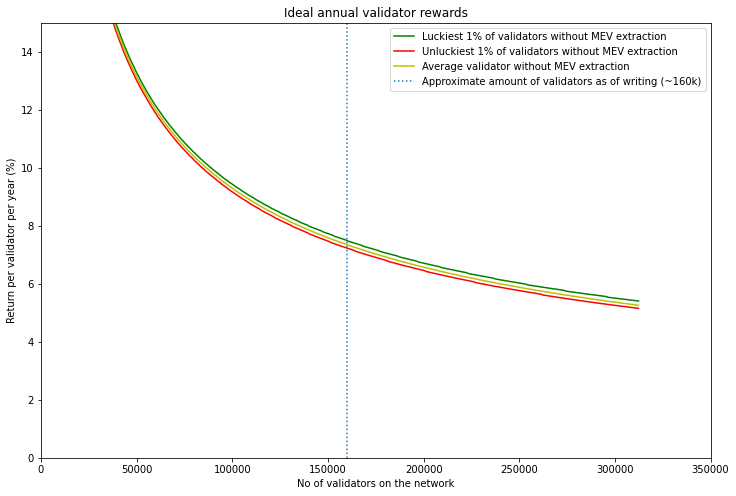

In [48]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))
# 3rd parameter below sets the color: https://matplotlib.org/stable/tutorials/colors/colors.html
# green => luckiest, red => unluckiest, yellow => average
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'g', label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'r', label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'y', label='Average validator without MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_title('Ideal annual validator rewards')
# Set limits on X/Y axis
axes = plt.gca()
axes.set_xlim([0,350000]) #min, max
axes.set_ylim([0,15])
leg = ax.legend();

Now overlaying MEV rewards on top:

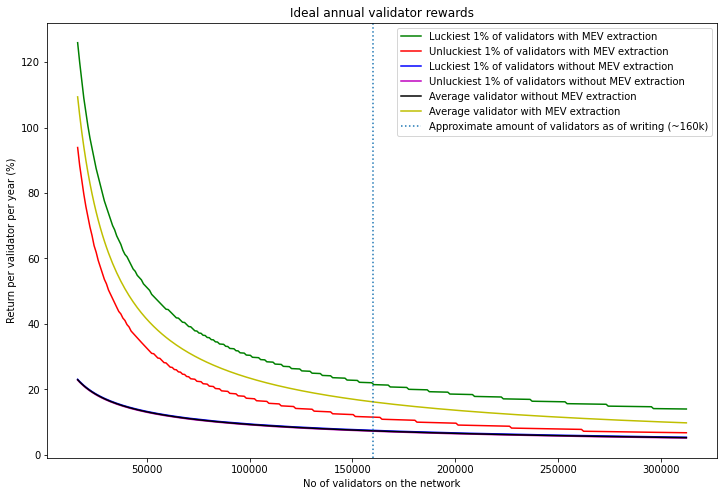

In [49]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , 'g', label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], 'r', label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'b', label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'm', label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'k', label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], 'y', label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_title('Ideal annual validator rewards')
#ax.set_yscale("log")
# Set limits on X/Y axis
leg = ax.legend();

### Adding a diferent dimension to luck: accounting for variation in REV

The above only considers luck in the sense of being assigned the opportunity of producing blocks. We know however that there is also a wide variation in the amount of Realized Extractable Value going to the miner in the different blocks. We account for that variation by considering the distribution of miner REV (only Flashbots bundles for ~100k blocks) jointly with the block producing one. 

As these are independent, we can redefine the "luckiest 1%" to be the intersection (product) of the luckiest 10% in the block producing sense with that of the luckiest 10% in the miner REV sense. Note that this is a coarse metric simply taking the 10/90 quantiles of the REV distribution (as opposed to sampling from the tails), so only gives a rough approximation of the REV-induced variation, particularly considering that the distribution is long-tailed (see below).

In [50]:
# Import miner REV data from file, from Mined Bundles table of the mev Metabase dataset
data = pd.read_csv('./miner-REV.csv') # relative path, dtype={'Miner Reward': np.int64})
miner_rev = data['Miner Reward']

In [51]:
# Cast data to int, ETH units
eth_miner_rev = miner_rev.apply(lambda x: int(x)/1e18)
lucky_rev_10 = eth_miner_rev.quantile(0.9)
unlucky_rev_10 = eth_miner_rev.quantile(0.1)
median_rev = eth_miner_rev.quantile(0.5)
print("Miner reward:")
print("Unluckiest 10% wrt REV = {} ETH".format(unlucky_rev_10))
print("Median wrt REV = {} ETH".format(median_rev))
print("Luckiest 10% wrt REV = {} ETH".format(lucky_rev_10))

Miner reward:
Unluckiest 10% wrt REV = 0.030704303972868115 ETH
Median wrt REV = 0.09956401092199615 ETH
Luckiest 10% wrt REV = 0.4110056481296545 ETH


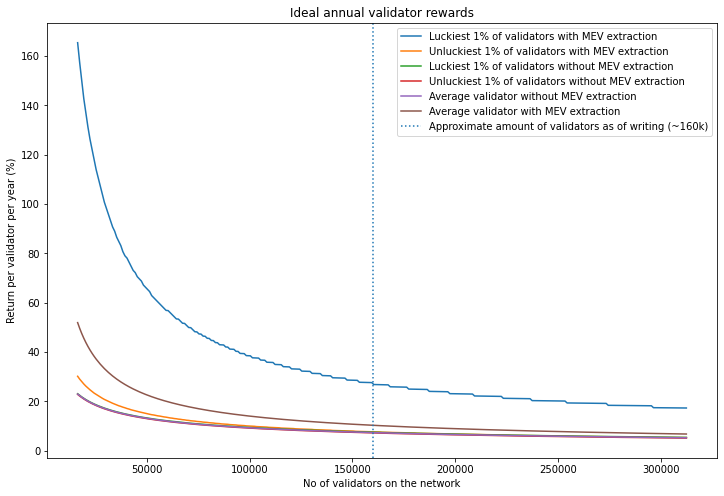

In [52]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (median_rev * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quantiles for ideal reward, based on block proposal opportunties and miner REV
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * unlucky_rev_10 * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * lucky_rev_10 * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_title('Ideal annual validator rewards')
#ax.set_yscale("log")
leg = ax.legend();

For comparison, we plot the same considering only the variation due to REV.

In [53]:
# Cast data to int, ETH units
lucky_rev_1 = eth_miner_rev.quantile(0.99)
unlucky_rev_1 = eth_miner_rev.quantile(0.01)
print("Unluckiest 1% REV = {} ETH".format(unlucky_rev_1))
print("Luckiest 1% REV = {} ETH".format(lucky_rev_1))

Unluckiest 1% REV = 0.01 ETH
Luckiest 1% REV = 1.9015241387672068 ETH


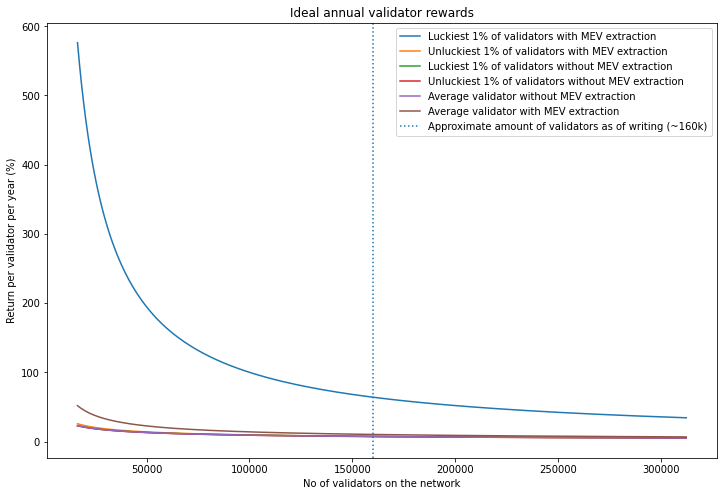

In [54]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (median_rev * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quantiles for ideal reward, based on block proposal opportunties and miner REV
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (mean_bpo[i] * unlucky_rev_1 * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (mean_bpo[i] * lucky_rev_1 * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_title('Ideal annual validator rewards')
#ax.set_yscale("log")
leg = ax.legend();

This goes to show that the variation due to miner REV is much larger than that given by block proposal assingments.

Finally, we look at the actual miner REV distribution, to have a deeper sense of where the variation is coming from

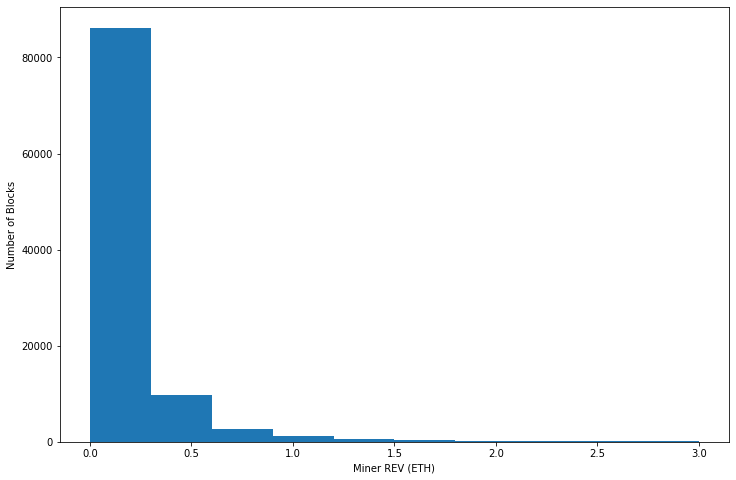

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(eth_miner_rev, range=((0, 3)));
ax.set_xlabel('Miner REV (ETH)');
ax.set_ylabel('Number of Blocks');

Here, we truncated the x axis to 3 ETH for visibility, but let's see how far the rewards go.

In [56]:
print("Max miner REV: ", max(eth_miner_rev), " ETH")

Max miner REV:  101.163273721  ETH


So we re-do the histogram with the full range in log scale:

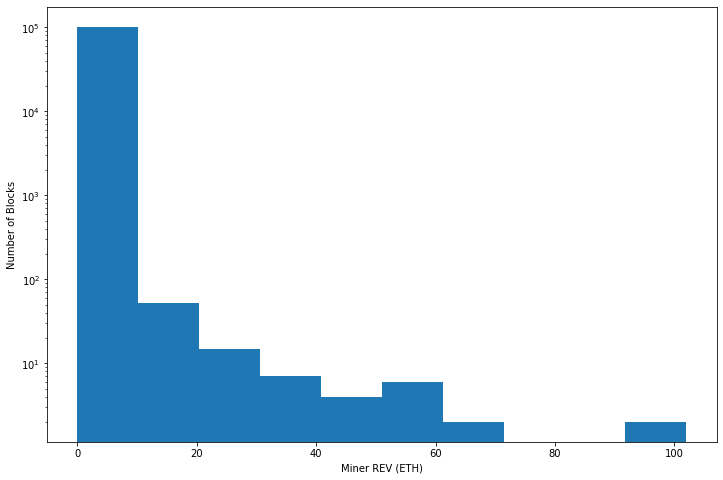

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(eth_miner_rev, range=((0, 102)), log=True);
ax.set_xlabel('Miner REV (ETH)');
ax.set_ylabel('Number of Blocks');

### Adding in slashing constraints: perfect validator on an imperfect network 

Now that we've modelled the above, we can look into versions of the model that factor in slashing constraints. The first situation to model is a perfect validator on an imperfect network. Validators get slashed not only for their own behavior but for the behaviour of others. Even if a validator behaves perfectly, other's behaviour may influence their reward. In particular, Pintail outlines two reasons perfect validators can get slashed:
- the accuracy reward is scaled by the proportion of active validators who voted the same way
- if an attestation of the perfect validator is included late because the block producer for the slot is offline, then the inclusion reward declines in inverse proportion to the inclusion delay.


In [58]:
# plot reward for perfect validator in several participation level contexts

participation_rate = [1,0.99,0.98,0.97,0.96]

n_validators = [n for n in range(50000,int(10e6)//32,1000)]
base_reward = [annualised_base_reward(n) for n in n_validators]

r_100000_without_mev = []
r_100000_with_mev = []

for P in participation_rate:
    accuracy_rewards = [P * 3 * r for r in base_reward]
    if P < 1:
        inclusion_reward = [(7/8) * r * P * math.log(P) / (P-1) for r in base_reward]
    else:
        inclusion_reward = [(7/8) * r for r in base_reward]
        
    block_reward = [(1/8) * r * P for r in base_reward]
    
    mev_reward = [avg_mev_reward_per_block * average_blocks_proposed_per_year(n)* (block_selection_frequency_flashbots/100) for n in n_validators]
    
    total_reward = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i]
                    for i in range(len(block_reward))]
    
    total_reward_with_mev = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i] + mev_reward[i]
                    for i in range(len(block_reward))]
    r_100000_without_mev.append(total_reward[50])
    r_100000_with_mev.append(total_reward_with_mev[50])

print(f'at P = {participation_rate[1]:.2f}, rewards without MEV fall by {100 * (1 - r_100000_without_mev[1] / r_100000_without_mev[0]):.2f}%, opposed to {100 * (1 - r_100000_with_mev[1] / r_100000_with_mev[0]):.2f}% with MEV')
print(f'at P = {participation_rate[2]:.2f}, rewards without MEV fall by {100 * (1 - r_100000_without_mev[2] / r_100000_without_mev[0]):.2f}%, opposed to {100 * (1 - r_100000_with_mev[2] / r_100000_with_mev[0]):.2f}% with MEV')
print(f'at P = {participation_rate[3]:.2f}, rewards without MEV fall by {100 * (1 - r_100000_without_mev[3] / r_100000_without_mev[0]):.2f}%, opposed to {100 * (1 - r_100000_with_mev[3] / r_100000_with_mev[0]):.2f}% with MEV')
print(f'at P = {participation_rate[4]:.2f}, rewards without MEV fall by {100 * (1 - r_100000_without_mev[4] / r_100000_without_mev[0]):.2f}%, opposed to {100 * (1 - r_100000_with_mev[4] / r_100000_with_mev[0]):.2f}% with MEV')

at P = 0.99, rewards without MEV fall by 0.89%, opposed to 0.35% with MEV
at P = 0.98, rewards without MEV fall by 1.78%, opposed to 0.71% with MEV
at P = 0.97, rewards without MEV fall by 2.68%, opposed to 1.06% with MEV
at P = 0.96, rewards without MEV fall by 3.57%, opposed to 1.41% with MEV


### adding in slashing constraints: imperfect validator on a perfect network

Now looking at an imperfect validator on a perfect network (ie. where our validator is the only one who goes offline), we can model how being offline affects a validator's revenue. Being offline causes 1) missing out some rewards, 2) penalties for missed attestations. Again, using Pintail's model we can find the minimum online time required in a year to receive a positive net reward.

First, without MEV rewards added in:

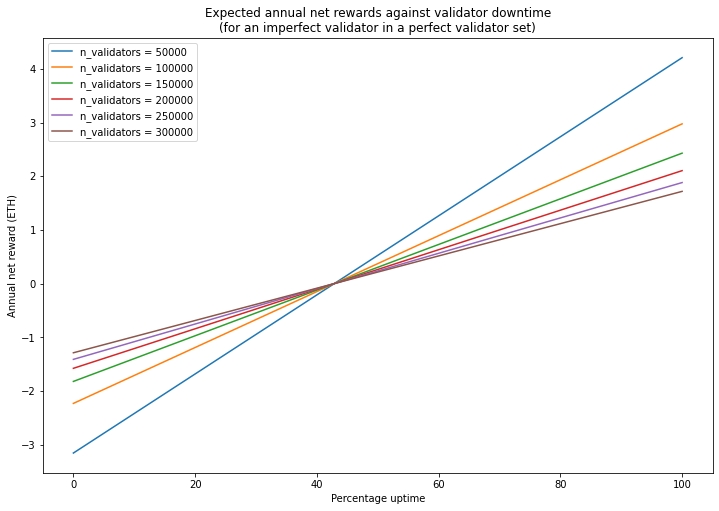

In [59]:
# plot expected reward for imperfect validator/perfect network at various validator set sizes

n_validators = [50000, 100000, 150000, 200000, 250000, 300000]
uptime = [i / 100 for i in range(101)]

fig, ax = plt.subplots(figsize=(12, 8))
for n in n_validators:
    base_reward = annualised_base_reward(n)
    net_reward = []
    for u in uptime:
        rewards = 4 * u * base_reward
        penalties = 3 * (1 - u) * base_reward
        net_reward.append(rewards - penalties)

    ax.plot(range(101), net_reward, label=f'n_validators = {n}')

ax.set_xlabel('Percentage uptime')
ax.set_ylabel('Annual net reward (ETH)')
ax.set_title('Expected annual net rewards against validator downtime\n'
             '(for an imperfect validator in a perfect validator set)')
leg = ax.legend()

Without MEV, the minimum uptime necessary is about 43%. Now with MEV:

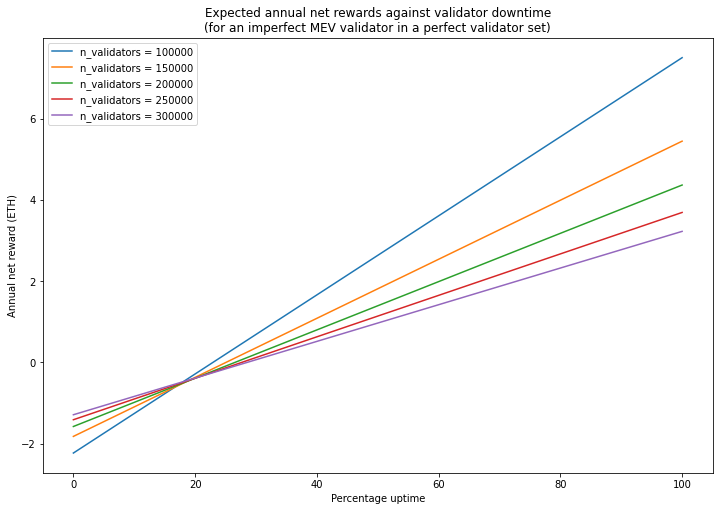

In [60]:
# Imperfect Validator on a Perfect Network

n_validators = [100000, 150000, 200000, 250000, 300000]
uptime = [i / 100 for i in range(101)]

fig, ax = plt.subplots(figsize=(12, 8))
for n in n_validators:
    base_reward = annualised_base_reward(n)
    mev_reward = average_blocks_proposed_per_year(n) * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100)
    net_reward = []
    for u in uptime:
        rewards = 4 * u * base_reward
        penalties = 3 * (1 - u) * base_reward
        mev_reward_adjusted_for_uptime = u * mev_reward
        net_reward.append(rewards - penalties + mev_reward_adjusted_for_uptime)

    ax.plot(range(101), net_reward, label=f'n_validators = {n}')

ax.set_xlabel('Percentage uptime')
ax.set_ylabel('Annual net reward (ETH)')
ax.set_title('Expected annual net rewards against validator downtime\n'
             '(for an imperfect MEV validator in a perfect validator set)')
leg = ax.legend()
#Skewed under 0 because we take average # of blocks proposed, need to repeat for luckiest/unluckiest 1%

The minimum uptime figure we find is now at about 20%, significantly lower than 43%. 

### summary of analysis

At the current number of ETH staked on the beacon chain (~160k):
1. validators stand to make an additional 2.83 eth per year from MEV revenue, or a 120% increase in average expected rewards, equivalent to an MEV-enabled 16.2% average annual staying yield vs 7.35% without MEV.
2. MEV rewards, and its uneven distribution, amplifies the inequality between luckiest and unluckiest validators with respect to block proposal luck.
3. MEV rewards softens penalities well-behaved validators would suffer from other validator's downtime.
4. MEV rewards lower the minimum uptime needed from a validator in order to be net positive.

#### future model improvements & caveats
- accounting for transaction fees using EIP-1559 numbers once it's live
- factoring in fee burn as being generally accretive to all ETH holders (including validators)
- factoring in more complex distributions

    